# 9. Variational Autoencoder

Tym razem zajmiemy się modelem VAE. W porównaniu do zwykłego autoenkodera, VAE w warstwie latent space próbuje utrzymać rozkład normalny. Dzieje się to dzięki dwuczęściowej funkcji kosztu, która z jednej strony jest kosztem rekonstrukcji podobnym do rekonstrukcji autoenkodera, z drugiej strony porównuje latent space z próbkowanym rozkładem normalnym:

$$ \mathcal{L}(X, z) = \mathbb{E}[\log P(X|z)] - D_{KL}[Q(z|X) || P(z)] $$

- $P(X|z)$ - rozkład generowanych danych przy danej zmiennej ukrytej $z$ (dekoder)
- $P(z)$ - rozkład prawdopodobieństwa zmiennej ukrytej
- $Q(z|X)$ - rozkład zmiennej ukrytej przy danym $X$ (enkoder)

Pierwszą część funkcji kosztu można obliczyć przy pomocy kosztu regresji logistycznej (binarna entropia krzyżowa). Drugą część można rozpisać:

$$ D_{KL}[N(\mu(X), \Sigma(X)) || N(0, 1)] = \frac{1}{2} \sum_k \left(\exp(\Sigma(X)) + \mu^2(X) - 1 - \Sigma(X)\right)$$

![VAE](utils/VAE.png)

### Setup

In [1]:
%matplotlib inline

from utils.draw_utils import plot_digits

import torch

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=False) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

### Zadanie 1. VAE

Zaimplementować VAE, nadbudowując kod z ostatnich zajęć. Autoenkoder powinien składać się z warstw liniowych (z nieliniową aktywacją np. `tanh`) w enkoderze: 
   * wejściowa (rozmiar cyfry z MNISTA)
   * rozmiaru 128
   * rozmiaru 64
   * rozmiaru 12
   * 2 warstw rozmiaru `latent_dim` odpowiadająych średniej $\mu$ i wariancji $\Sigma$
   
oraz reparametryzacji obliczającej $z$ na podstawie $\mu$ i $\Sigma$, oraz dekodera z dokładnie odwrotnym przekształceniem.

In [6]:
class VAE(torch.nn.Module):
    
    def __init__(self, latent_dim):
        
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        D = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 128), 
            torch.nn.Tanh(), 
            torch.nn.Linear(128, 64), 
            torch.nn.Tanh(), 
            torch.nn.Linear(64, 12), 
        ).cuda()
        
        self.mu_layer = torch.nn.Linear(12, latent_dim).cuda()
        self.var_layer = torch.nn.Linear(12, latent_dim).cuda()
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 12),
            torch.nn.Tanh(), 
            torch.nn.Linear(12, 64), 
            torch.nn.Tanh(), 
            torch.nn.Linear(64, 128),
            torch.nn.Tanh(), 
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        ).cuda()
        
    def reparametrize(self, mu, logvar):
        # use reparametrization trick
        z = torch.randn_like(mu).cuda()
        return (torch.exp(0.5 * logvar) * z + mu).cuda()
    
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        enc = self.encoder(x)
        return self.mu_layer(enc), self.var_layer(enc)

    def forward(self, x):
        # encode, reparametrize, and decode
        mu, var = self.encode(x)
        z = self.reparametrize(mu, var)
        return z, self.decode(z), mu, var

## Zadanie 2: Pętla Uczenia

Uzupełnić brakujące fragmenty kodu uczenia oraz funkcji kosztu.

Running on CUDA
Epoch:  0 | train loss: 34768.4609


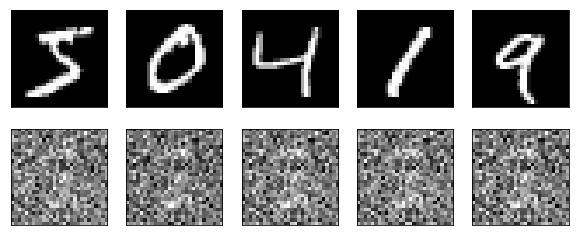

Epoch:  0 | train loss: 11633.2686


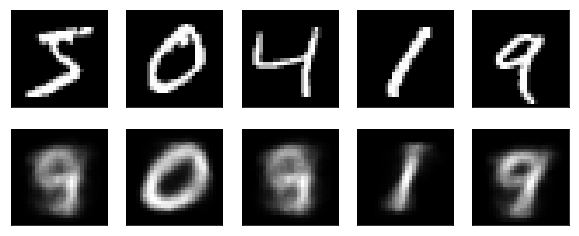

Epoch:  5 | train loss: 10346.0879


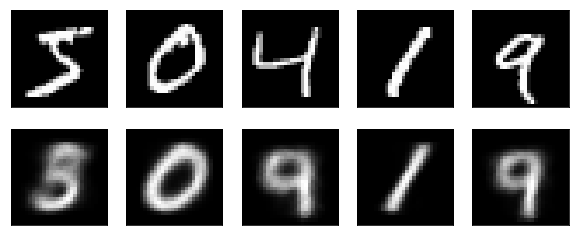

Epoch:  5 | train loss: 11061.0928


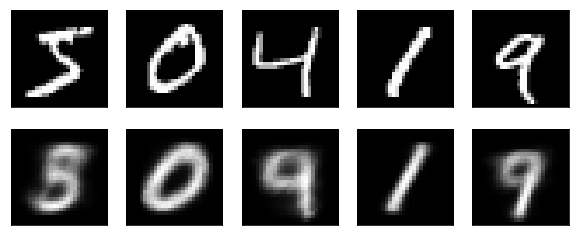

Epoch:  9 | train loss: 11004.4824


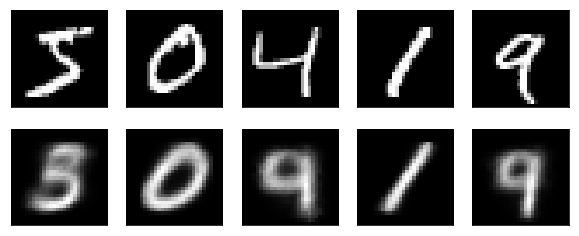

Epoch:  9 | train loss: 11132.5547


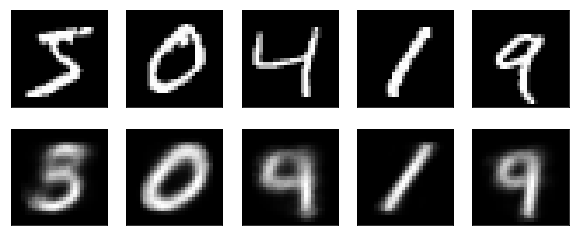

In [7]:
# Hyper Parameters
epochs = 10
LR = 0.005         # learning rate
n_plots = 5
latent_dim = 3

# prepare original data for plotting
view_data = train_data.train_data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.


autoencoder = VAE(latent_dim = latent_dim)
if torch.cuda.is_available():
    print('Running on CUDA')
    autoencoder.cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

def loss_func(x_decoded, x, z_mu, z_var):
    BCE = F.binary_cross_entropy(x_decoded, x.cuda(), reduction='sum').cuda() # use binary cross entropy as reconstruction loss
    KLD = -0.5 * torch.sum(1 + z_var - z_mu.pow(2) - z_var.exp()) # implement Kullback-Leibler divergence (formula above)
    return BCE + KLD

for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded, mu, var = autoencoder(x.cuda())

        loss = loss_func(decoded, x, mu, var) # calculate loss
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data, _, _ = autoencoder(view_data.cuda())
            
            plot_digits(view_data.cpu(), decoded_data.cpu())

## Wizualizacja warstwy ukrytej

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for step, (x, y) in enumerate(train_loader):
    z = autoencoder(x.cuda())[0].cpu().detach().numpy()
    ax.scatter(z[:, 0], z[:, 1], z[:, 2], c = y)
    if step == 10:
        break
plt.show()

## Zadanie 3: Generowanie

Wylosować 5 punktów z rozkładu N(0,1) i wygenerować z nich cyfry MNIST przy pomocy dekodera. Teraz już nie musimy liczyć statystyk latent space'a, bo znamy rozkład zmiennej $z$.

tensor([[-0.5310, -0.7805,  1.1298],
        [-1.1024,  0.0966,  1.3110],
        [ 0.5366, -1.3260, -1.7052],
        [-0.1466,  0.5017, -1.4150],
        [-0.8987, -0.7089, -0.2922]], device='cuda:0')


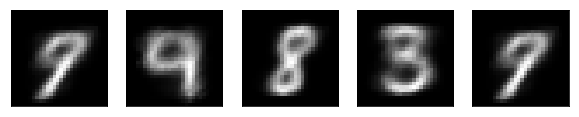

In [10]:
%matplotlib inline

z_sampled = torch.randn(5, 3).cuda() # sample 5 points in the latent space
print(z_sampled)
x_decoded = autoencoder.decode(z_sampled) # decode the sampled points

plot_digits(x_decoded.cpu())

## Zadanie 4: Interpolacja

Analogicznie do przykładu z poprzednich zajęć pokazać interpolację między cyframi.

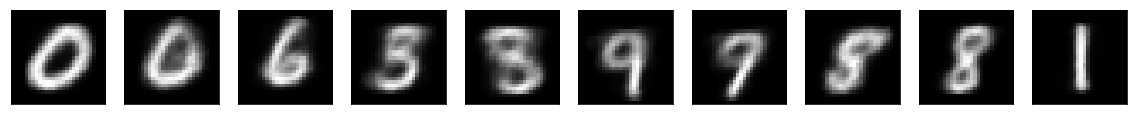

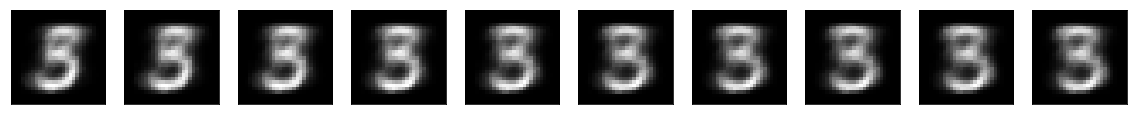

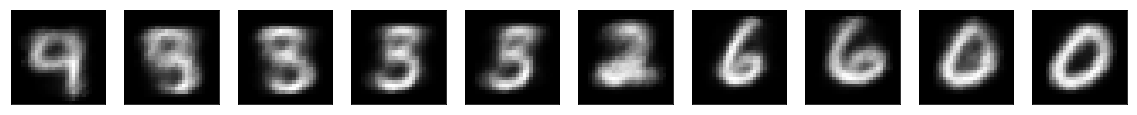

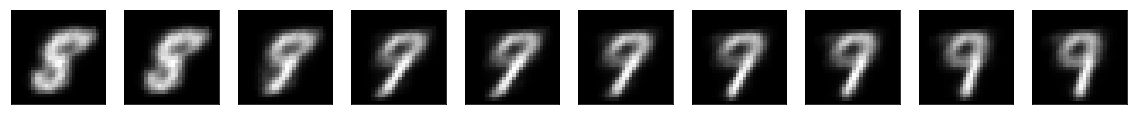

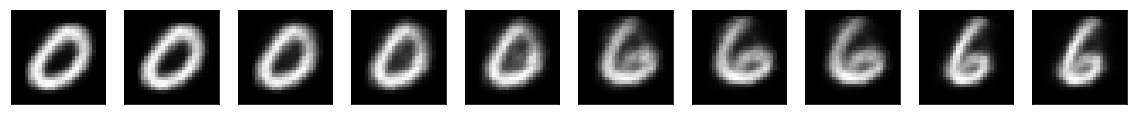

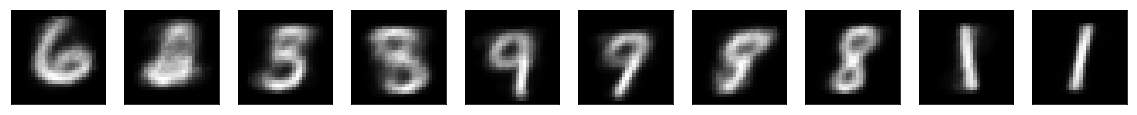

In [12]:
%matplotlib inline

n_interpolations = 5

for step, (x, y) in enumerate(train_loader):
    if step > n_interpolations:
        break
    
    x_a = x[0, :]
    x_b = x[1, :]
    
    mu_a, var_a = autoencoder.encode(x_a.cuda())
    z_a = autoencoder.reparametrize(mu_a, var_a)
    mu_b, var_b = autoencoder.encode(x_b.cuda())
    z_b = autoencoder.reparametrize(mu_b, var_b)
    
    x_interpolated = []
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1-alpha) * z_a + alpha * z_b # interpolate in the latent space
        x_int = autoencoder.decode(z_int) # decode the interpolated sample

        
        x_interpolated.append(x_int)
    
    x_interpolated = torch.stack(x_interpolated, dim=0)
    
    plot_digits(x_interpolated.cpu())